## PGPM - Synthetic Signal Generation

```NB Version 2.5```

This notebook demonstrates the use of drawing samples from the piecewise Gaussian process 
model described in the DSP2025 paper _A Piecewise Gaussian Process Model for Evaluating
Training and Performance of Time-Series Pipelines_. 

The signal model was initially used to develop both the architecture and training strategy for deep network architectures that consumed time-series and provided a dense labelling of the temporal axis according to the nature of the activity occurring within an interval of time. 

The notebook focusses on interpreting and conveying the nature of this simple model. We have found the signals useful in a number of projects in which the goal is to test time-series labelling. It should be seen as a providing "test signals" as used in 
engineering to characterise the input/output mappings of engineered systems. Unlike many techniques that depend on impulse responses, input sine-waves, or noise sources, the form of the discrete-time signals generated by this code are finite support, and inspired by test signals from electrical engineering. They may be of particular use in:

 - Regression testing for deep deep networks that perform dense temporal segmentation.

 - Testing of interpretability techniques for whole (temporal)-axis signal classifiers, 
   since ground truth can be specified.

 - Systematic studies of noise-robustness for either classification or dense segmentation 
   techniques. 

The entropy of amplitude distributions of the signals in the current version of the model are non-stationary; signal occlusion/partial observation is not supported, but the signal characteristics can be made quite non-trivial to discern.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.stats import entropy
from datagenerator import generate_data, makesignal, get_params_from_json

In [3]:
sns.set_theme(style='white')
sns.set(rc={'figure.figsize':(10,6)}, font_scale=2.5)
sns.set_style({'axes.facecolor':'white', 'grid.color': '.8', 'font.family':'Times New Roman'})

plt.rcParams.update({
    "text.usetex": True,
})

In [4]:
params = get_params_from_json('./Parameters/params.json')

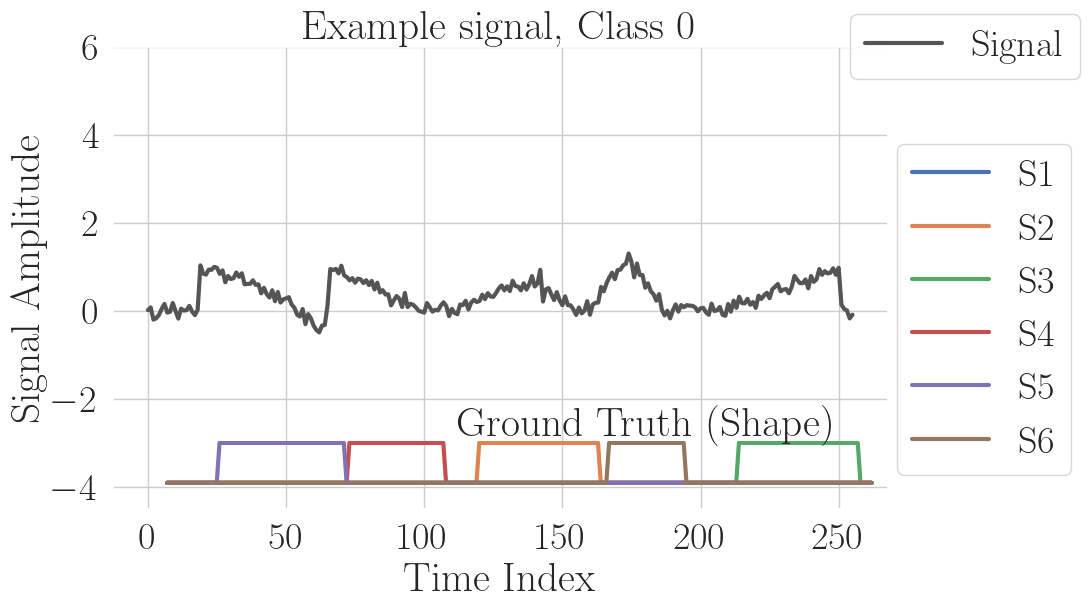

In [5]:
# A single realisation of a signal, with different types of components
fig,ax = plt.subplots(1)

params['noise_level'] = 0.1 # Set for this example "draw"
y, gt, sigclass = makesignal(params)

sigLength, nSegTypes = gt.shape

ax.plot(range(sigLength), y[0,:], lw=3, color='#555555')
ax.set_title('Example signal, Class ' + str(sigclass))
plt.gca().set_prop_cycle(None)
# ax.plot(range(len(y[0,:])),gt)
ax.set_ylim([-4.5, 6.0])
ax.set_ylabel('Signal Amplitude')
ax.set_xlabel('Time Index')
ax.legend(['Signal'], bbox_to_anchor=(1.1, 1), loc='center')
axins = inset_axes(ax, width="100%", height="10%", 
                    bbox_to_anchor=(0.0, 0.01, 1.0, 0.95),
                    bbox_transform=ax.transAxes, loc=3)

plt.gca().set_prop_cycle(None)
axins.set_axis_off()
axins.text(105,1.2,'Ground Truth (Shape)')
axins.plot(gt,lw=3)
axins.legend(['S1','S2','S3','S4','S5','S6'],
             bbox_to_anchor=(1.1, 4), loc='center')
plt.savefig('Figures/signalshapedemo.svg')

In [6]:
# A single sample will have a ground truth 2-tensor where the 
# first dimension (dim 0) tells you about the length of the signal, and
# the second (dim 1) tells you about the number of shape waveforms that
# could be present.
gt.shape

(256, 6)

## Simple interpretation of shape outputs
This is how you get the element-wise shape labelling for all 6 channels, representing a one-hot shape class encoding. Please note that this is a *dense* classification: we do not assume a single shape per signal, but a shape assignment per sample. Easiest analogy is the comparison between a UNet (semantic segmentation, producing dense labels) and a classifier like AlexNeet, which produces a single class output per input image.

In [7]:
np.argmax(gt,axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0])

# How variable are the signals?
To illustrate variability of the signals, have a look at the following example.

In [8]:
# This generates 20 separate signal examples - no offset
params['noise_level'] = 0.0 # Focus on shape for this example "draw"
params['randomoffset'] = False
num_signals = 20

# A sample is a complete signal (vector); we generate num_signals of these
input_signals_A, target_masks_A, signalclass_A = generate_data(params, num_samples=num_signals)

# This generates 20 separate signal examples - random offset to start of shapes
params['randomoffset'] = True
input_signals_B, target_masks_B, signalclass_B = generate_data(params, num_samples=num_signals)


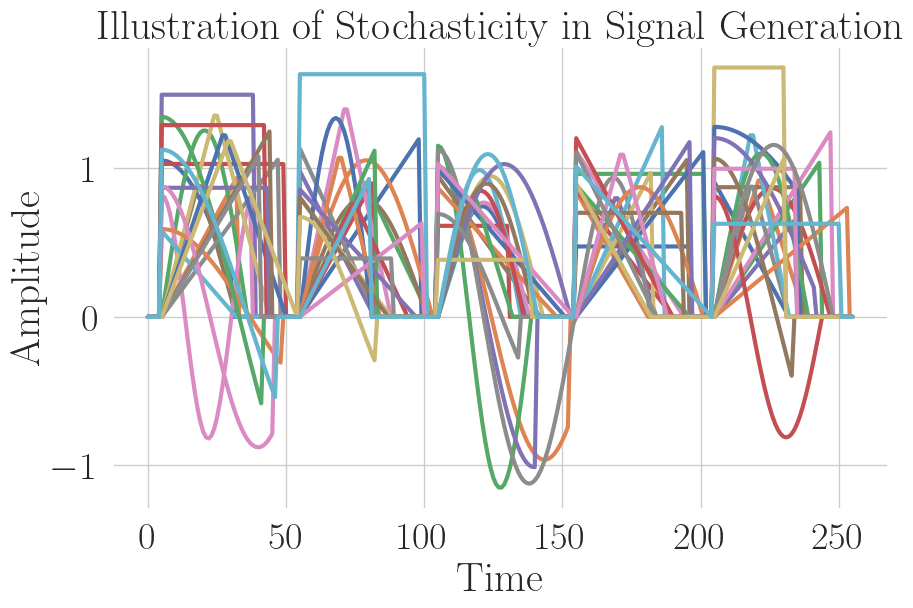

In [9]:
plt.plot(np.transpose(input_signals_A),lw=3)
plt.title('Illustration of Stochasticity in Signal Generation')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.savefig('Figures/stochasticity-1.svg')

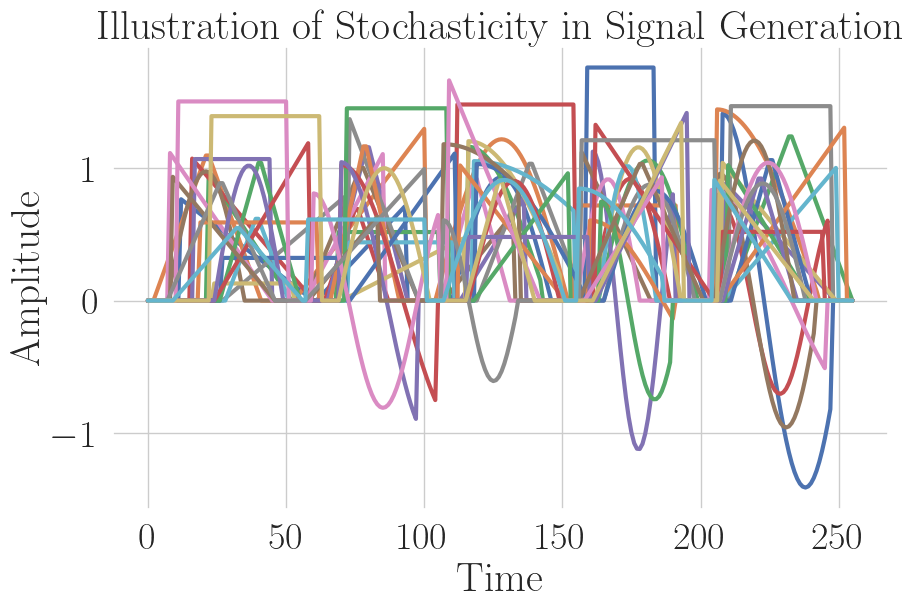

In [10]:
plt.plot(np.transpose(input_signals_B),lw=3)
plt.title('Illustration of Stochasticity in Signal Generation')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.savefig('Figures/stochasticity-2.svg')

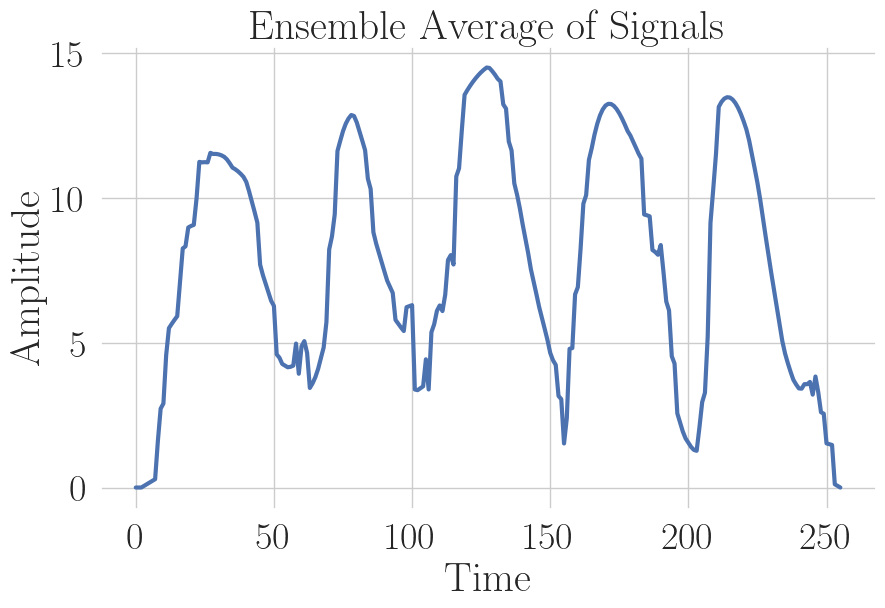

In [11]:
plt.plot(np.sum(input_signals_B,axis=0),lw=3)
plt.title('Ensemble Average of Signals')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.savefig('Figures/EE-NoiseFree')

# Adding Noise...
First, with no random offset for signal start.

Text(0, 0.5, 'Amplitude')

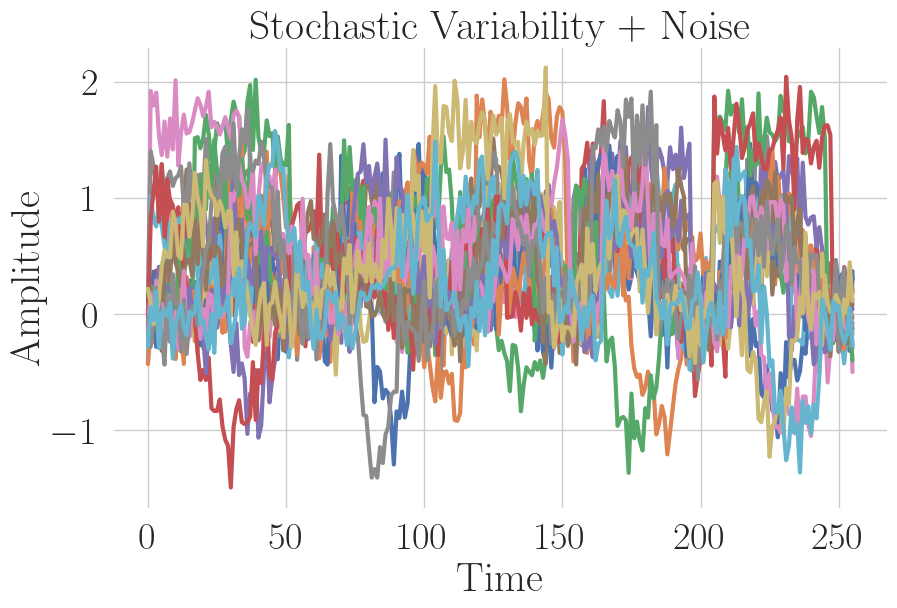

In [12]:
# This generates 20 separate signal examples - with noise
params['noise_level'] = 0.2 
num_signals = 20

input_signals, target_masks, sigclass = generate_data(params, num_samples=num_signals)
plt.plot(np.transpose(input_signals), lw=3)
plt.title('Stochastic Variability + Noise')
plt.xlabel('Time')
plt.ylabel('Amplitude')

Now, with random starting offset to the  signals.

/var/folders/19/0fvgmwsn1f51ykrhrxvl7prm0000gn/T/ipykernel_89032/1836736643.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


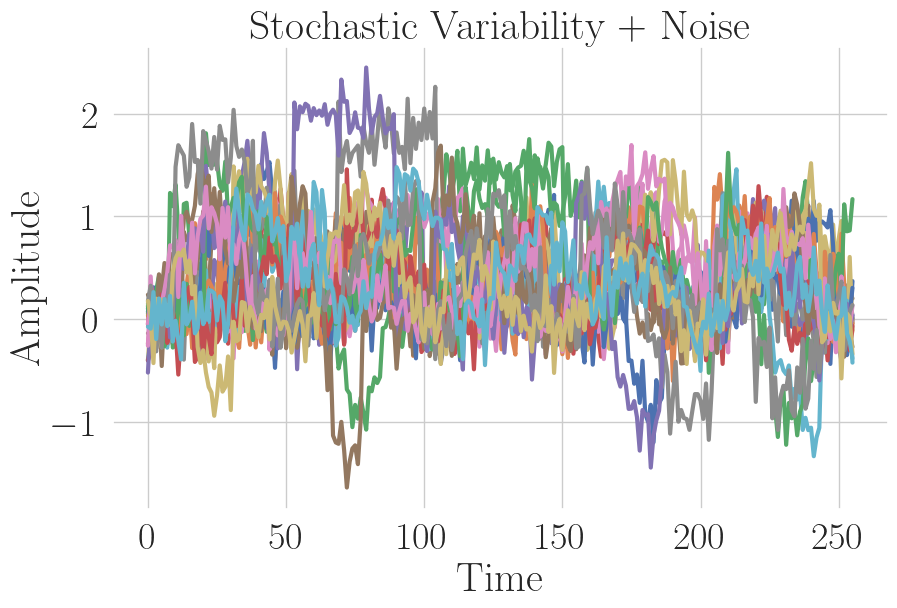

In [13]:
# This generates 20 separate signal examples
params['randomoffset'] = True
num_signals = 20


input_signals, target_masks, sigclass = generate_data(params, num_samples=num_signals)
plt.plot(np.transpose(input_signals), lw=3)
plt.title('Stochastic Variability + Noise')
plt.xlabel('Time')
plt.ylabel('Amplitude')
fig.tight_layout()
plt.savefig('Figures/SignalNoiseAndVariability.svg')

## Statistical Measures of Signal Variability

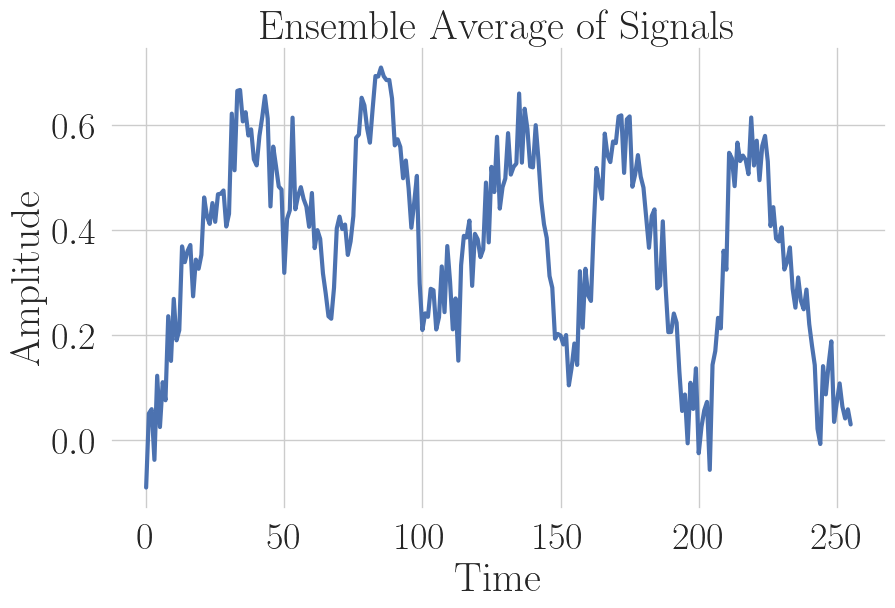

In [14]:
plt.plot(np.mean(input_signals,axis=0),lw=3)
plt.title('Ensemble Average of Signals')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.savefig('Figures/EE.svg')

In [15]:
## Amplitude entropy of signals: computed as a function of discrete time


# Set parameters as sigma C = 0 
params['randomoffset'] = True
params['noise_level'] = 0.0

num_signals = 10000 # Number of signals to generate

input_signals_A, target_masks, signalclass = generate_data(params, num_samples=num_signals)

min_amplitude = np.min(input_signals_A)
max_amplitude = np.max(input_signals_A)

TheoreticalGivenRange_A = np.log2(max_amplitude - min_amplitude) # Maximum entropy for a uniform dist, continuous space

# Theoretical result given binned distribution
BinnedeEntropy = np.log2(100) # Maximum entropy for a uniform dist

[_, H_A] = np.histogram([max_amplitude,min_amplitude], bins=100, density=True)

entropy_amplitudes_A = np.zeros(257)
for i, t_k in enumerate(range(0,256)):
    amplitudes = input_signals_A[:,t_k]
    min_amplitude = np.min(input_signals_A)
    max_amplitude = np.max(input_signals_A)
    amplitudes = amplitudes - min_amplitude
    pA, _ = np.histogram(amplitudes, bins=H_A, density=True)
    entropy_amplitudes_A[i] = entropy(pA, base=2)




In [16]:
## Amplitude entropy of signals: computed as a function of discrete time


# Set parameters as sigma C = 0.2 I
params['randomoffset'] = True
params['noise_level'] = 0.2

num_signals = 10000 # Number of signals to generate

input_signals_B, target_masks, signalclass = generate_data(params, num_samples=num_signals)


min_amplitude = np.min(input_signals_B)
max_amplitude = np.max(input_signals_B)

TheoreticalGivenRange_B = np.log2(max_amplitude - min_amplitude) # Maximum entropy for a uniform dist
[pB, H_B] = np.histogram([max_amplitude,min_amplitude], bins=100, density=True)

entropy_amplitudes_B = np.zeros(257)
for i, t_k in enumerate(range(0,256)):
    amplitudes = input_signals_B[:,t_k]
    min_amplitude = np.min(input_signals_B)
    max_amplitude = np.max(input_signals_B)
    pB, _ = np.histogram(amplitudes, bins=H_B, density=True)
    entropy_amplitudes_B[i] = entropy(pB, base=2)


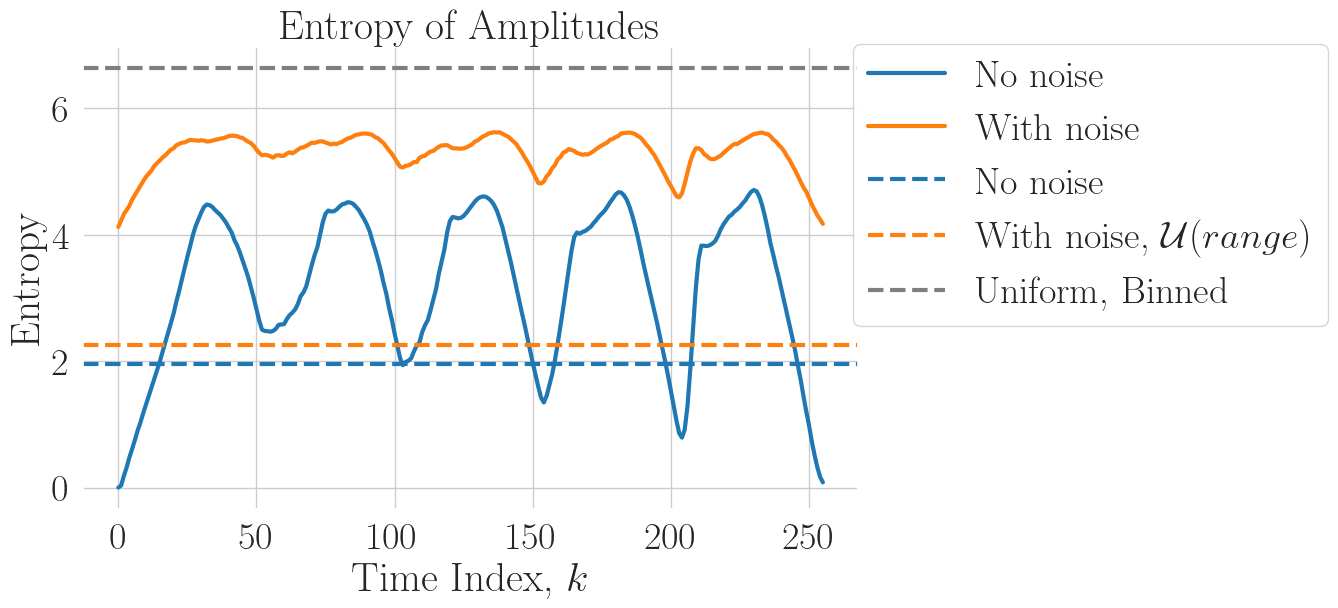

In [17]:
fig, ax = plt.subplots(1)
empNF = ax.plot(range(0,256), entropy_amplitudes_A[:-1], lw=3, color='tab:blue')
empN = ax.plot(range(0,256), entropy_amplitudes_B[:-1], lw=3, color='tab:orange')
ax.axhline(TheoreticalGivenRange_A, color='tab:blue', lw=3, ls='--')
ax.axhline(TheoreticalGivenRange_B, color='tab:orange', lw=3, ls='--')
ax.axhline(BinnedeEntropy, color='tab:grey', lw=3, ls='--')

plt.title('Entropy of Amplitudes')
plt.xlabel('Time Index, $k$')
plt.ylabel('Entropy')
plt.legend(['No noise', 'With noise', 'No noise', 
             'With noise, $\\mathcal{U}(range)$', 'Uniform, Binned'], 
            bbox_to_anchor=(1.3, 0.7), loc='center')
plt.savefig('Figures/EntropyOfAmplitudes.svg')  

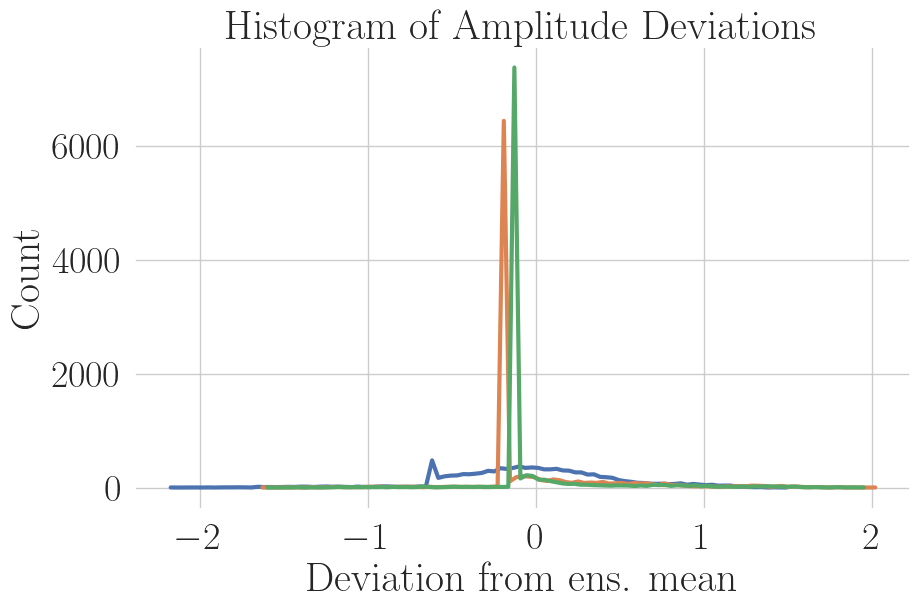

In [18]:
mufnofk = np.mean(input_signals_A, axis=0)
meancorrected = input_signals_A - mufnofk
[N1,H1] = np.histogram(meancorrected[:,75], bins=100)
[N2,H2] = np.histogram(meancorrected[:,150], bins=100)
[N3,H3] = np.histogram(meancorrected[:,200], bins=100)
plt.plot(H1[:-1],N1,H2[:-1],N2,H3[:-1],N3, lw=3)
plt.title('Histogram of Amplitude Deviations')
plt.xlabel('Deviation from ens. mean')
plt.ylabel('Count')
plt.savefig('Figures/HistOfAmplitudes.svg')

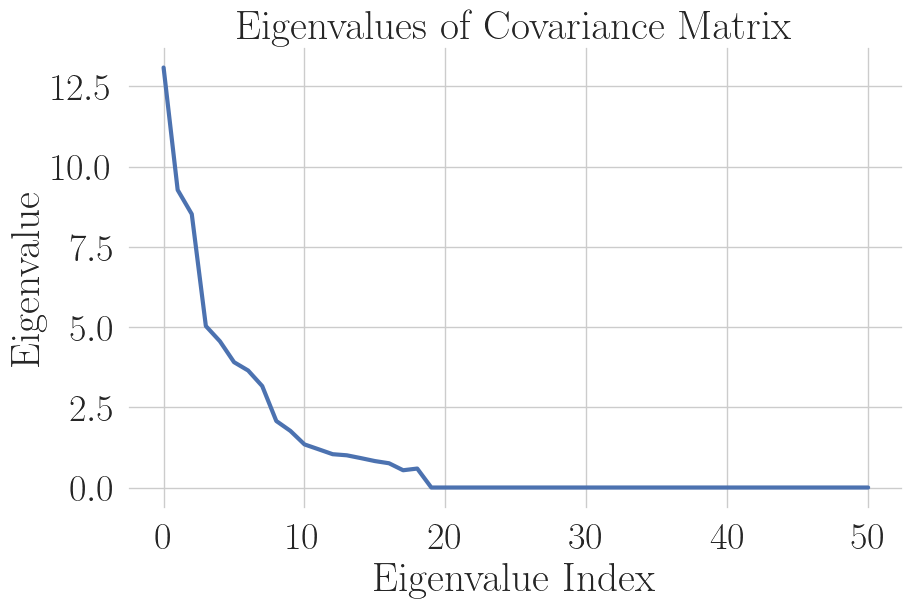

In [19]:
# The eigenstructure of the covariance matrix arguably provides
# an indication of the complexity of the temporal structure of signals.

cov = np.cov(input_signals.T)
[eigvals, eigvecs] = np.linalg.eig(cov)
plt.plot(np.real(eigvals[0:51]), lw=3)
plt.title('Eigenvalues of Covariance Matrix')
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue')
plt.savefig('Figures/EigenvaluesOfCovarianceMatrix.svg')

## Illustrating variability of individual components
If we were to generate a collection of signals and use the accompanying ground truth to
examine the variability of signal support, amplitude and shape, we are able to 
get a good feel for the nature of shape variations present in a signal ensemble.

There are very occasional phase/polarity changes; sometimes only one is visible at a time,
dependent on the sampled amplitude parameter. Since this is drawn from a Gaussian distribution, widening this distribution or reducing its mean will yield to more common amplitude sign flips, if that is relevant for your application.

In [20]:
# This will be used to collect examples of waveform shapes extracted from a 
# small ensemble of signals (20). This will be used to demonstrate waveform shape
# variability.
params = get_params_from_json('./Parameters/params.json')
params['noise_level'] = 0.0 # Set for this example "draw"

y, gt, sigclass = generate_data(params, num_samples=20)

In [21]:
nSamples, sigLength, nSegTypes = gt.shape

# Assume 80 as the max support required; will 
# register centres of all intervals to # be at location 40
maxSuppLength = 80

ShapeStartIndex = np.zeros((nSamples, nSegTypes))
ShapeEndIndex = np.zeros((nSamples, nSegTypes))


for i in range(nSegTypes):
    # Loop over a batch
    for j in range(nSamples):
        w = np.nonzero(gt[j,:,i].squeeze())
        if not w[0].size==0:
            ShapeStartIndex[j,i] = np.min(w[0])
            ShapeEndIndex[j,i] = np.max(w[0])
        else:
            ShapeStartIndex[j,i] = 0
            ShapeEndIndex[j,i] = 0

# Assume 50 as the max support required; will register centres of all intervals to # be at location 25
ShapeEnsembles = np.zeros((nSamples,maxSuppLength,nSegTypes))
for i in range(nSegTypes):
    for j in range(nSamples):
        midInterval = int((ShapeStartIndex[j,i] + ShapeEndIndex[j,i])/2)
        StartLoc = int(maxSuppLength/2+ShapeStartIndex[j,i] - midInterval)
        EndLoc = int(maxSuppLength/2+ShapeEndIndex[j,i] - midInterval)
        ShapeEnsembles[j,StartLoc:EndLoc,i] = y[j,
                    int(ShapeStartIndex[j,i]):int(ShapeEndIndex[j,i])]

In [22]:
np.shape(ShapeEnsembles)

(20, 80, 6)

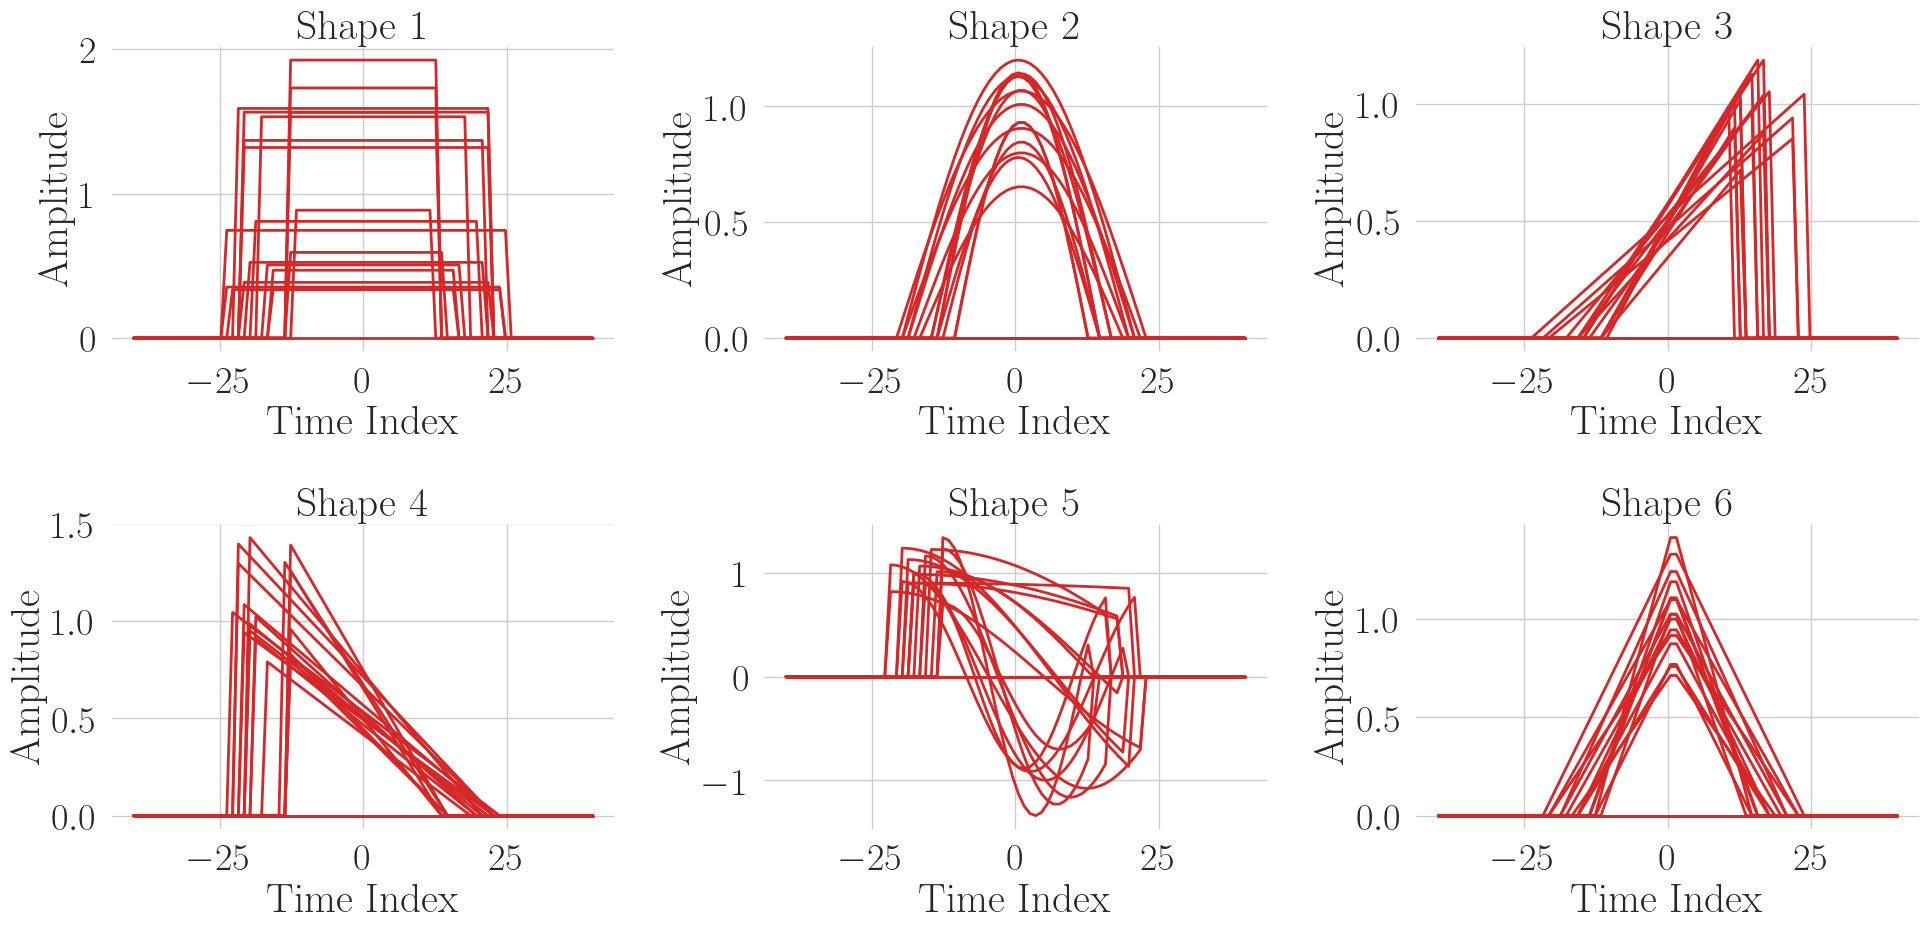

In [23]:
fig, axs = plt.subplots(2,3, figsize=(20,10))
axs=axs.flatten()
xaxis = np.linspace(-maxSuppLength/2,maxSuppLength/2,maxSuppLength)
for i in range(nSegTypes):
    axs[i].plot(xaxis, (ShapeEnsembles[:,:,i]).T, color='tab:red',lw=2)
    axs[i].set_title('Shape ' + str(i+1))
    axs[i].set_xlabel('Time Index')
    axs[i].set_ylabel('Amplitude')
fig.tight_layout()
plt.savefig('Figures/ShapesEnsembles.svg')

## Explore Signal Classes 0 and 1 at Signal Level
### This is really for whole-signal classification studies

Each "full" signal (of length 256 in the original paper and examples) is also assigned a class identity, which is typified by two characteristics: 1) a different distributions of amplitudes on the square wave portion of the signal, 2) different _frequency_ characteristics on the cosine waveform. Here, we explore the second of these, assuming that the `cosine' waves are given angular frequency $\omega_0$ for class 0 and $\omega_1$ for class 1. 

The expressions used to demonstrate the distributions are based on the `DG.py` code, though parameters settings will depend on parameter settings in the `params.json` file. We do not generate the signals themselves, only demonstrate that the distributions are slightly different, though overlapping in one dimension of the 2D space that distinguishes between the two classes.

The different classes have features that are captured by two different waveform types; if both waveforms are present, the features are present at more than one location in the signal (useful if ones to check that saliency measures can capture both). If only one of the two class-information bearing waveforms is present, then the features are present at only one location in the signal.

In [24]:
signalclass = 0
delta0 = params['hyperparams']['FreqDeltaSigma']*np.random.randn(100) + (float(signalclass)-0.5)

In [25]:
signalclass = 1
delta1 = params['hyperparams']['FreqDeltaSigma']*np.random.randn(100) + (float(signalclass)-0.5)

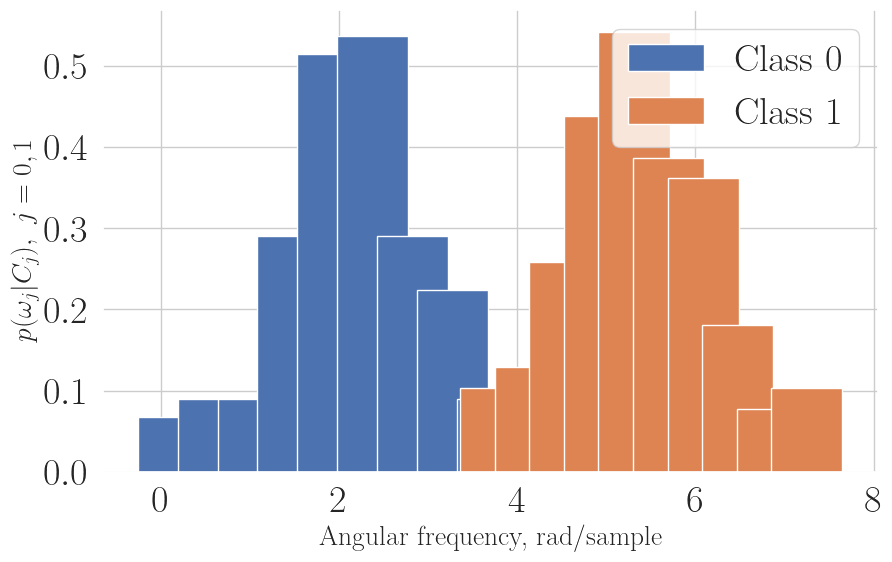

In [26]:
# What does this particular feature - frequency - look like in its parameter space
H0, X0 = np.histogram((1+delta0)*np.pi,10)
H1, X1 = np.histogram((1+delta1)*np.pi,10)
dX0 = X0[1] - X0[0]
dX1 = X1[1] - X1[0]
pH0 = H0/(np.sum(H0*dX0))
pH1 = H1/(np.sum(H1*dX1))
plt.bar(X0[1:]+dX1,pH0)
plt.bar(X1[1:]+dX1,pH1)
plt.xlabel('Angular frequency, rad/sample',fontsize=20)
plt.ylabel('$p(\\omega_j|C_j),\\,\\, j=0,1$',fontsize=20)
plt.legend(('Class 0','Class 1'))
plt.savefig('Figures/CosFreqDist.svg')

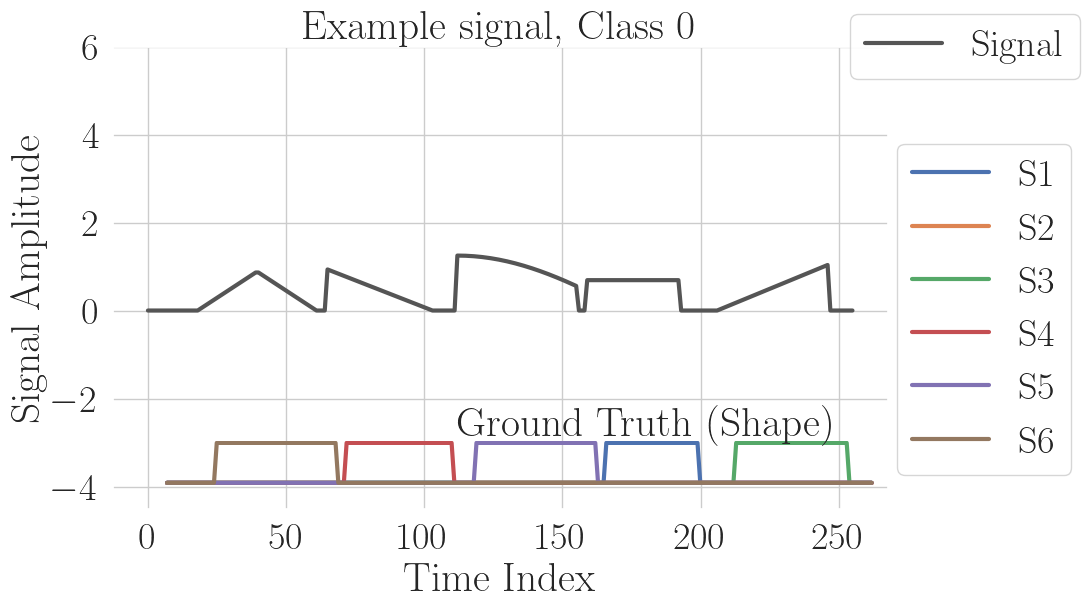

In [27]:
# Each time this code block is run, there is a single class generated.... can you
# tell which class is generated each time? [I can't!]
fig,ax = plt.subplots(1)
params = get_params_from_json('./Parameters/params.json')
params['noise_level'] = 0.0 # Set for this example "draw"


y, gt, sigclass = generate_data(params, num_samples=1)

nSamples, sigLength, nSegTypes = gt.shape

# Signal 0 from the batch - could take a random choice up to nSamples-1:
sampleToPlot = 0

ax.plot(range(sigLength), y[sampleToPlot,:], lw=3, color='#555555')
ax.set_title('Example signal, Class ' + str(int(sigclass[0])))
plt.gca().set_prop_cycle(None)
# ax.plot(range(len(y[0,:])),gt)
ax.set_ylim([-4.5, 6.0])
ax.set_ylabel('Signal Amplitude')
ax.set_xlabel('Time Index')
ax.legend(['Signal'], bbox_to_anchor=(1.1, 1), loc='center')
axins = inset_axes(ax, width="100%", height="10%", 
                    bbox_to_anchor=(0.0, 0.01, 1.0, 0.95),
                    bbox_transform=ax.transAxes, loc=3)

plt.gca().set_prop_cycle(None)
axins.set_axis_off()
axins.text(105,1.2,'Ground Truth (Shape)')
axins.plot(gt[sampleToPlot,:,:],lw=3)
axins.legend(['S1','S2','S3','S4','S5','S6'],
             bbox_to_anchor=(1.1, 4), loc='center')